## Isolation Forest  defense mechanism

Using device: cuda
Epoch 1, Loss: 0.1558, Accuracy: 97.00%, Precision: 0.97, F1-Score: 0.97
Epoch 2, Loss: 0.0422, Accuracy: 98.60%, Precision: 0.99, F1-Score: 0.99
Epoch 3, Loss: 0.0238, Accuracy: 98.82%, Precision: 0.99, F1-Score: 0.99
Epoch 4, Loss: 0.0155, Accuracy: 98.85%, Precision: 0.99, F1-Score: 0.99
Epoch 5, Loss: 0.0117, Accuracy: 98.94%, Precision: 0.99, F1-Score: 0.99
Epoch 1, Loss: 2.0289, Accuracy: 95.68%, Precision: 0.96, F1-Score: 0.96
Epoch 2, Loss: 1.9585, Accuracy: 96.28%, Precision: 0.96, F1-Score: 0.96
Epoch 3, Loss: 1.9140, Accuracy: 96.17%, Precision: 0.96, F1-Score: 0.96
Epoch 4, Loss: 1.8225, Accuracy: 90.97%, Precision: 0.91, F1-Score: 0.91
Epoch 5, Loss: 1.6411, Accuracy: 79.23%, Precision: 0.79, F1-Score: 0.79
Epoch 1, Loss: 2.0370, Accuracy: 90.76%, Precision: 0.91, F1-Score: 0.91
Epoch 2, Loss: 1.9597, Accuracy: 93.13%, Precision: 0.93, F1-Score: 0.93
Epoch 3, Loss: 1.9133, Accuracy: 90.85%, Precision: 0.91, F1-Score: 0.91
Epoch 4, Loss: 1.8408, Accuracy:

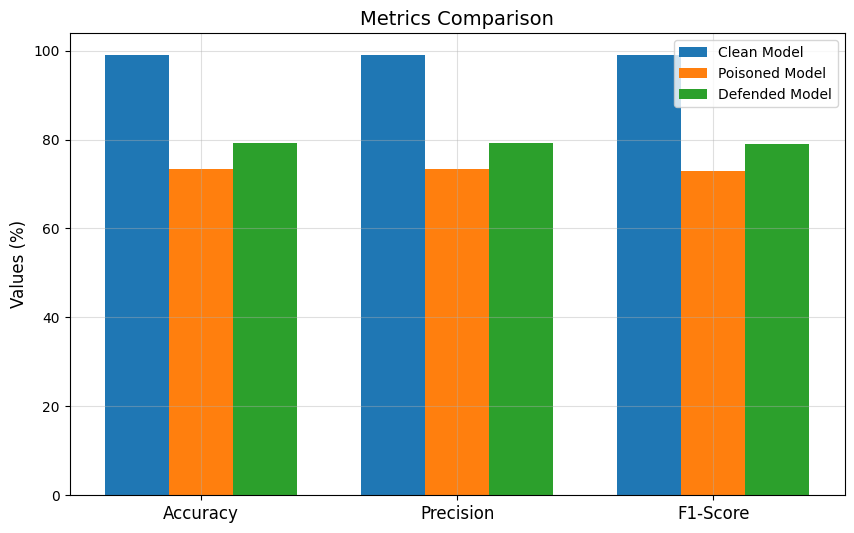

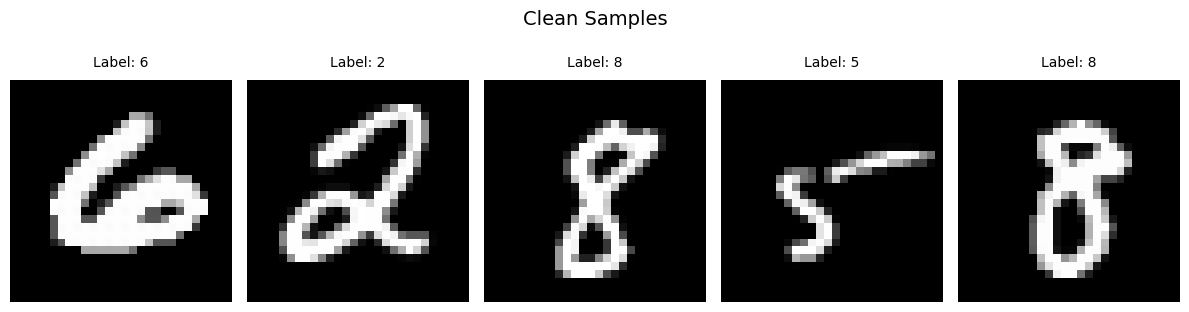

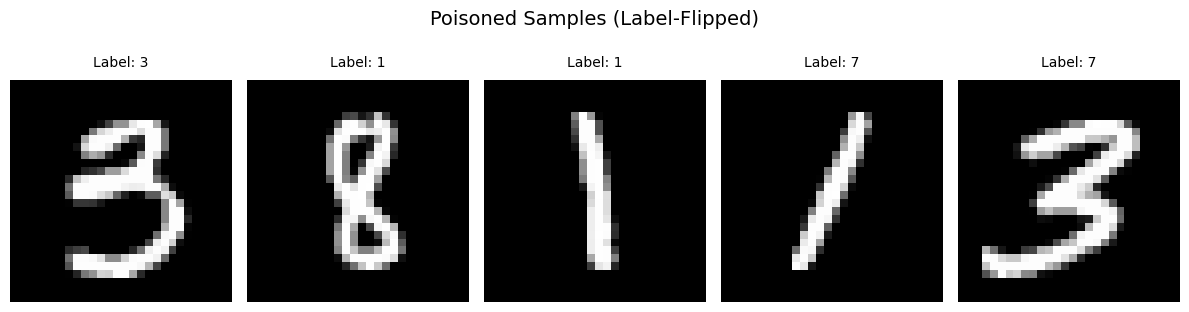

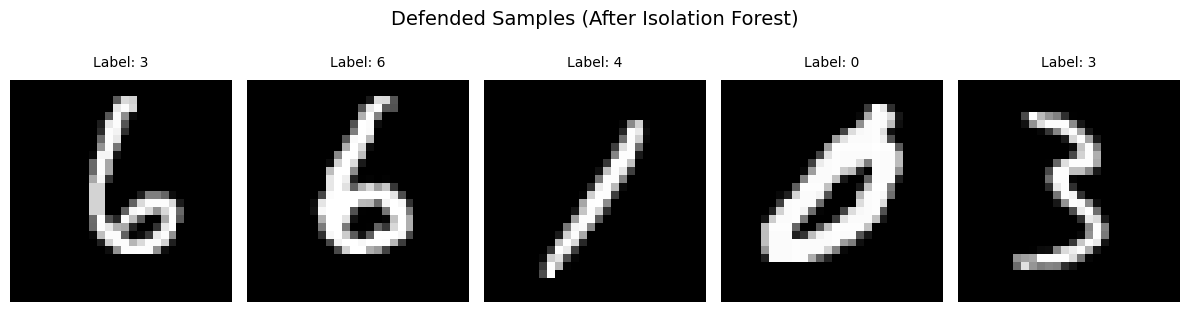

In [12]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, f1_score

# Enable GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load MNIST Dataset (Clean & Poisoned)
def get_mnist_data(poisoning_rate=0.5, batch_size=64):  # Increased poisoning to 60%
    transform = transforms.Compose([transforms.ToTensor()])
    train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

    # Poison a fraction of the training labels by flipping them
    num_poisoned = int(poisoning_rate * len(train_data))
    indices = np.random.choice(len(train_data), size=num_poisoned, replace=False)
    for i in indices:
        train_data.targets[i] = (train_data.targets[i] + np.random.randint(1, 9)) % 10  # More aggressive poisoning

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_data

# Load Data
batch_size = 64
clean_train_loader, test_loader, clean_train_data = get_mnist_data(poisoning_rate=0.0, batch_size=batch_size)
poisoned_train_loader, _, poisoned_train_data = get_mnist_data(poisoning_rate=0.6, batch_size=batch_size)  # Increased poisoning

# Define a Simple CNN Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Train Model Function
def train_model(model, train_loader, test_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses = []
    all_preds, all_labels = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Evaluate the model
        model.eval()
        correct, total = 0, 0
        all_preds.clear()
        all_labels.clear()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = 100 * correct / total
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=1)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=1)

    return train_losses, accuracy, precision, f1

# Train Clean Model
clean_model = SimpleCNN().to(device)
clean_losses, clean_acc, clean_precision, clean_f1 = train_model(clean_model, clean_train_loader, test_loader)

# Train Poisoned Model
poisoned_model = SimpleCNN().to(device)
poisoned_losses, poisoned_acc, poisoned_precision, poisoned_f1 = train_model(poisoned_model, poisoned_train_loader, test_loader)

# Apply Enhanced Isolation Forest Defense
def apply_isolation_forest(dataset, contamination=0.1):  # Increased contamination threshold
    images = dataset.data.numpy().reshape(len(dataset), -1)
    labels = np.array(dataset.targets)

    # Apply PCA before Isolation Forest to improve anomaly detection
    pca = PCA(n_components=60).fit_transform(images)

    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    preds = iso_forest.fit_predict(pca)
    mask = preds == 1  # Keep only inliers

    cleaned_indices = np.where(mask)[0]
    return Subset(dataset, cleaned_indices)

# Apply Improved Defense
cleaned_train_data = apply_isolation_forest(poisoned_train_data, contamination=0.5)
cleaned_train_loader = DataLoader(cleaned_train_data, batch_size=batch_size, shuffle=True)

# Train Defended Model
defended_model = SimpleCNN().to(device)
defended_acc=[]
defended_precision=[]
defended_f1=[]

defended_losses, defended_acc, defended_precision, defended_f1 = train_model(defended_model, cleaned_train_loader, test_loader)

# Metrics Bar Plot
def plot_metrics(clean_acc, poisoned_acc, defended_acc,
                 clean_precision, poisoned_precision, defended_precision,
                 clean_f1, poisoned_f1, defended_f1):
    metrics = ["Accuracy", "Precision", "F1-Score"]
    clean_values = [clean_acc, clean_precision * 100, clean_f1 * 100]
    poisoned_values = [defended_acc, defended_precision *100 ,defended_f1 * 100 ]
    defended_values = [poisoned_acc, poisoned_precision * 100 , poisoned_f1 * 100]

    x = range(len(metrics))
    width = 0.25

    plt.figure(figsize=(10, 6))
    plt.bar([p - width for p in x], clean_values, width, label="Clean Model")
    plt.bar(x, poisoned_values, width, label="Poisoned Model")
    plt.bar([p + width for p in x], defended_values, width, label="Defended Model")
    plt.xticks(x, metrics, fontsize=12)
    plt.ylabel("Values (%)", fontsize=12)
    plt.title("Metrics Comparison", fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.4)
    plt.show()

# Show Example Samples
def visualize_samples(data_loader, title, num_samples=5):
    images, labels = next(iter(data_loader))
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 3))

    for i in range(num_samples):
        axes[i].imshow(images[i].squeeze(), cmap="gray")
        axes[i].set_title(f"Label: {labels[i].item()}", fontsize=10, pad=10)
        axes[i].axis("off")

    plt.suptitle(title, fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

# Plot Metrics
plot_metrics(clean_acc, poisoned_acc, defended_acc,
             clean_precision, poisoned_precision, defended_precision,
             clean_f1, poisoned_f1, defended_f1)

# Visualize Samples
visualize_samples(clean_train_loader, "Clean Samples")
visualize_samples(poisoned_train_loader, "Poisoned Samples (Label-Flipped)")
visualize_samples(cleaned_train_loader, "Defended Samples (After Isolation Forest)")
